# Import packages

In [7]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os, sys
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break

import sys


from data_wrangling import specific_utils, process_monkey_information, base_processing_class, retrieve_raw_data, further_processing_class
from pattern_discovery import pattern_by_trials, pattern_by_points, make_ff_dataframe, ff_dataframe_utils, pattern_by_trials, pattern_by_points, cluster_analysis, organize_patterns_and_features, category_class
from decision_making_analysis.cluster_replacement import cluster_replacement_utils, plot_cluster_replacement
from decision_making_analysis.decision_making import decision_making_utils, plot_decision_making, intended_targets_classes
from decision_making_analysis.GUAT import GUAT_helper_class, GUAT_collect_info_class, GUAT_combine_info_class, add_features_GUAT_and_TAFT
from decision_making_analysis import free_selection, replacement, trajectory_info
from visualization.matplotlib_tools import plot_trials, plot_polar, additional_plots, plot_behaviors_utils, plot_statistics, monkey_heading_utils
from visualization.animation import animation_func, animation_utils, animation_class
from machine_learning.ml_methods import regression_utils, classification_utils, prep_ml_data_utils, hyperparam_tuning_class
from reinforcement_learning.base_classes import env_utils, base_env, more_envs, rl_base_class, rl_base_utils
from reinforcement_learning.agents.rnn import gru_utils, lstm_utils
from reinforcement_learning.agents.feedforward import interpret_neural_network, sb3_class, sb3_utils
from null_behaviors import show_null_trajectory, find_best_arc, curvature_utils
from decision_making_analysis.decision_making import decision_making_class, decision_making_utils, intended_targets_classes
import itertools

import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from os.path import exists
import seaborn as sns
import math
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from scipy import stats
from IPython.display import HTML
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from math import pi
from scipy.ndimage import gaussian_filter1d
from importlib import reload

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
pd.options.display.max_rows = 101



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decision making

There are two situations: 

Free selection:	One is when the monkey makes a decision among all possible ff (after catching the previous target)

Replacement:	The other is when the monkey changes its mind (or decides not to change the current course) while pursuing another ff.


## Free selection

In [2]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"

In [3]:
reload(decision_making_class)
reload(intended_targets_classes)

dm = decision_making_class.DecisionMaking(raw_data_folder_path=raw_data_folder_path,
                                            time_range_of_trajectory=[-2.5, 0], num_time_points_for_trajectory=5)
# dm.retrieve_manual_anno()
dm.get_monkey_data(already_retrieved_ok=True, include_ff_dataframe=True)
dm.make_curvature_df()
dm.make_auto_annot()
dm.manual_anno = dm.auto_annot
dm.manual_anno_long = dm.auto_annot_long

dm.separate_manual_anno()
dm.eliminate_crossing_boundary_cases(n_seconds_after_crossing_boundary = 2.5)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0330/ff_dataframe.h5
Number of unique ff in the dropped rows: 1416
The span of the data is 59.98 min
replacement_df: 3520 out of 4244 rows remains
free_selection_df: 1023 out of 1165 rows remains
non_chosen_df: 84055 out of 97345 rows remains


In [4]:
dm.get_replacement_x_df()
dm.get_free_selection_x()

dm.prepare_data_for_machine_learning(kind="free selection", furnish_with_trajectory_data=True, trajectory_data_kind="position") 
dm.split_data_to_train_and_test(scaling_data=True)
dm.use_machine_learning_model_for_classification(None)   
dm.get_pred_results_df()  



replacement_df = dm.replacement_df
free_selection_df = dm.free_selection_df
non_chosen_df = dm.non_chosen_df

changing_pursued_ff_data = dm.changing_pursued_ff_data
changing_pursued_ff_data_diff = dm.changing_pursued_ff_data_diff
replacement_time = dm.replacement_time
replacement_inputs = dm.replacement_inputs
replacement_labels = dm.replacement_labels

free_selection_x_df = dm.free_selection_x_df
free_selection_labels = dm.free_selection_labels
free_selection_time = dm.free_selection_time

Note: when calculating angles to ff centers, 893 rows are too close to the monkey/agent: less than 0.001 m. Their angles are set to 0.
Note: when calculating angles to ff centers, 893 rows are too close to the monkey/agent: less than 0.001 m. Their angles are set to 0.

 input features: ['ff_distance_0' 'time_since_last_vis_0' 'ff_angle_0' 'ff_distance_1'
 'time_since_last_vis_1' 'ff_angle_1' 'ff_distance_2'
 'time_since_last_vis_2' 'ff_angle_2' 'ff_distance_3'
 'time_since_last_vis_3' 'ff_angle_3' 'ff_distance_4'
 'time_since_last_vis_4' 'ff_angle_4' 'point_index'
 'monkey_distance_-2.5s' 'monkey_distance_-1.88s' 'monkey_distance_-1.25s'
 'monkey_distance_-0.62s' 'monkey_distance_0.0s'
 'monkey_angle_to_origin_-2.5s' 'monkey_angle_to_origin_-1.88s'
 'monkey_angle_to_origin_-1.25s' 'monkey_angle_to_origin_-0.62s'
 'monkey_angle_to_origin_0.0s' 'whether_stopped_-2.5s'
 'whether_stopped_-1.88s' 'whether_stopped_-1.25s'
 'whether_stopped_-0.62s' 'whether_stopped_0.0s'] 

Model: gnb
Model:

/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 28
[LightGBM] [Info] Start training from score -2.618238
[LightGBM] [Info] Start training from score -1.925091
[LightGBM] [Info] Start training from score -1.585875
[LightGBM] [Info] Start training from score -1.439583
[LightGBM] [Info] Start training from score -1.606637
[LightGBM] [Info] Start training from score -1.974362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model: knn
Model: mlp


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: svm
            model  accuracy  balanced_accuracy  precision_macro  recall_macro  \
5         bagging   0.26257            0.20635          0.31586       0.20635   
15            svm   0.25140            0.18391          0.13213       0.18391   
14            mlp   0.22905            0.21375          0.21464       0.21375   
8        boosting   0.22346            0.16078          0.11663       0.16078   
9   grad_boosting   0.22346            0.18769          0.21528       0.18769   
1          logreg   0.21229            0.17661          0.18277       0.17661   
2           ridge   0.21229            0.16484          0.15716       0.16484   
4              dt   0.21229            0.19256          0.21269       0.19256   
7     extra_trees   0.20670            0.16894          0.15542       0.16894   
10            xgb   0.20670            0.16970          0.15948       0.16970   
3             sgd   0.20112            0.16893          0.14925       0.16893   
6              rf

## plot predictions



Prediction: 4
Real: 3


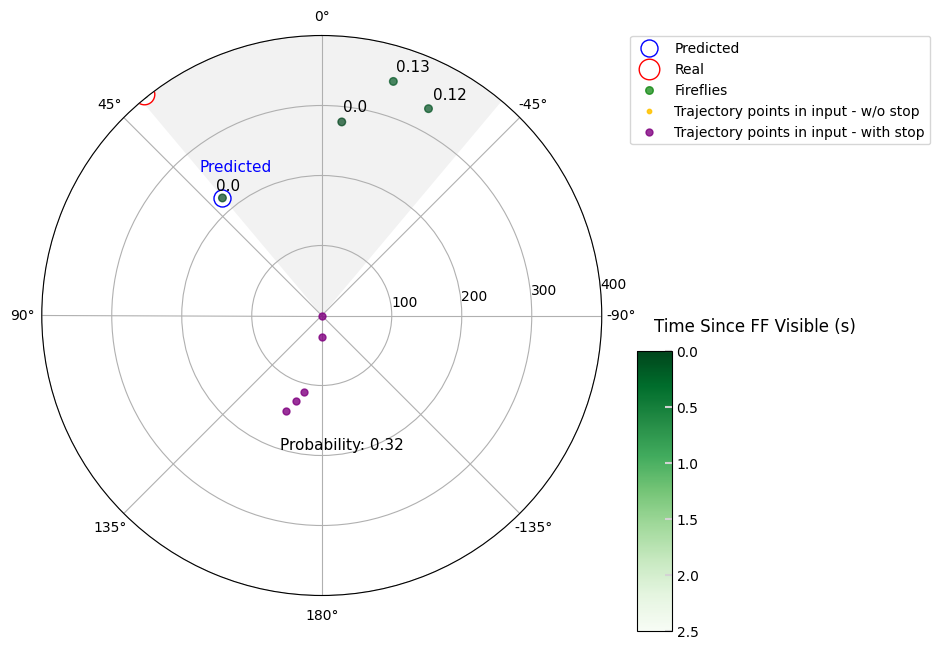



Prediction: 2
Real: 4


In [5]:
selected_cases = None
dm.prepare_to_plot_prediction_results()
dm.plot_prediction_results(selected_cases, max_plot_to_make=2)

# Hyperparameter tuning

### moit
Here, we tune parameters such as whether to pass in null arc info

In [8]:
# make a dictionary of all the ff attributes combinations
ff_attributes=['ff_distance', 'ff_angle', 'time_since_last_vis']
ff_attributes_combinations = []
for i in range(1, len(ff_attributes)+1):
    combo_w_i_elements = list(itertools.combinations(ff_attributes, i))
    ff_attributes_combinations.extend([list(combo) for combo in combo_w_i_elements])
    
grid = {'ff_attributes': ff_attributes_combinations,
        'trajectory_data_kind': ['position', 'velocity', None],
        'add_arc_info': [True, False],
        'add_current_curv_of_traj': [True, False],
        'keep_whole_chunks' : [True, False],
        'num_ff_per_row': [5, 6, 7],  # Note: here's an inherent limitation to this: data where the target is not within the n_ff_per_row ff are eliminated. So data can be biased.
        'time_range_of_trajectory': [[-0.9, 0], [-0.9, 0.9]]
        }

# sample all the combinations from the grid
keys, values = zip(*grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [ ]:
reload(pattern_by_trials)
reload(decision_making_class)
reload(decision_making_utils)
reload(show_null_trajectory)
reload(intended_targets_classes)
reload(regression_utils)

combo = combinations[0]
result_df = pd.DataFrame()
for i in range(len(combinations)):
    combo = combinations[i].copy()
    print(i, 'out of', len(combinations))
    print(combo)
    combo['n_seconds_after_crossing_boundary'] = abs(combo['time_range_of_trajectory'][0])
    combo['n_seconds_before_crossing_boundary'] = abs(combo['time_range_of_trajectory'][1])
    # hide all printed material for below
    with general_utils.HiddenPrints():
        # hide all ConvergenceWarning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            model_comparison_df = regression_utils.test_moit_hyperparameters(ff_dataframe, ff_caught_T_new, ff_real_position_sorted, monkey_information, ff_flash_sorted, ff_life_sorted, auto_annot, auto_annot_long,
                                curvature_df=curvature_df, select_every_nth_row=10, **combo)

    combo_for_df = combo.copy()
    combo_for_df['ff_attributes'] = [combo_for_df['ff_attributes']]
    combo_for_df['time_range_of_trajectory'] = [combo_for_df['time_range_of_trajectory']]
    # store the most accurate model
    combo_for_df['best_model'] = model_comparison_df.iloc[0]['model']
    # store the accuracy of the most accurate model
    combo_for_df['best_model_accuracy'] = round(model_comparison_df.iloc[0]['accuracy'], 3)
    # store the accuracies of all the other models
    for index, row in model_comparison_df.iterrows():
        combo_for_df[row['model']] = round(row['accuracy'], 3)
    temp_result_df = pd.DataFrame(combo_for_df)
    if i == 0:
        result_df = temp_result_df
    else:
        result_df = pd.concat([result_df, temp_result_df], axis=0)
    

In [ ]:
result_df

In [ ]:
stop!

### dm_replacement

In [ ]:
# make a dictionary of all the ff attributes combinations
ff_attributes=['ff_distance', 'ff_angle', 'time_since_last_vis']
ff_attributes_combinations = []
for i in range(1, len(ff_attributes)+1):
    combo_w_i_elements = list(itertools.combinations(ff_attributes, i))
    ff_attributes_combinations.extend([list(combo) for combo in combo_w_i_elements])
    
grid = {'ff_attributes': ff_attributes_combinations,
        'trajectory_data_kind': ['position', 'velocity', None],
        'add_arc_info': [True, False],
        'add_current_curv_of_traj': [True, False],
        'time_range_of_trajectory': [[-0.9, 0], [-0.9, 0.9]],
        'num_time_points_for_trajectory': [5, 10, 15],
        'replacement_inputs_format': ['diff_between_old_and_new', 'old_plus_diff_between_old_and_new', 'both_old_and_new'],
        }

# sample all the combinations from the grid
keys, values = zip(*grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [ ]:
reload(pattern_by_trials)
reload(decision_making_class)
reload(decision_making_utils)
reload(show_null_trajectory)
reload(intended_targets_classes)
reload(regression_utils)

combo = combinations[0]
dm_result_df = pd.DataFrame()
for i in range(len(combinations)):
    combo = combinations[i].copy()
    print(i, 'out of', len(combinations))
    print(combo)
    combo['n_seconds_after_crossing_boundary'] = abs(combo['time_range_of_trajectory'][0])
    combo['n_seconds_before_crossing_boundary'] = abs(combo['time_range_of_trajectory'][1])
    # hide all printed material for below
    with general_utils.HiddenPrints():
        # hide all ConvergenceWarning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            model_comparison_df = regression_utils.test_dm_replacement_hyperparameters(ff_dataframe, ff_caught_T_new, ff_real_position_sorted, monkey_information, auto_annot, curvature_df=curvature_df, **combo)

    combo_for_df = combo.copy()
    combo_for_df['ff_attributes'] = [combo_for_df['ff_attributes']]
    combo_for_df['time_range_of_trajectory'] = [combo_for_df['time_range_of_trajectory']]
    # store the most accurate model
    combo_for_df['best_model'] = model_comparison_df.iloc[0]['model']
    # store the accuracy of the most accurate model
    combo_for_df['best_model_accuracy'] = round(model_comparison_df.iloc[0]['accuracy'], 3)
    # store the accuracies of all the other models
    for index, row in model_comparison_df.iterrows():
        combo_for_df[row['model']] = round(row['accuracy'], 3)
    temp_result_df = pd.DataFrame(combo_for_df)
    if i == 0:
        dm_result_df = temp_result_df
    else:
        dm_result_df = pd.concat([dm_result_df, temp_result_df], axis=0)
    

In [ ]:

# def test_dm_replacement_hyperparameters(ff_dataframe, ff_caught_T_new, ff_real_position_sorted, monkey_information, auto_annot,
#                               add_arc_info=True, add_current_curv_of_traj=True, furnish_with_trajectory_data=True, num_time_points_for_trajectory=20,
#                               ff_attributes=['ff_distance', 'ff_angle', 'time_since_last_vis'], trajectory_data_kind=['position'], curvature_df=None,
#                               time_range_of_trajectory=[-0.8, 0.8], n_seconds_before_crossing_boundary=0.8, n_seconds_after_crossing_boundary=0.8,
#                               replacement_inputs_format = 'diff_between_old_and_new'):

#     dm = decision_making_class.DecisionMaking(raw_data_folder_path=raw_data_folder_path,
#                                             time_range_of_trajectory=time_range_of_trajectory, num_time_points_for_trajectory=num_time_points_for_trajectory)
#     dm.manual_anno = auto_annot
#     dm.separate_manual_anno()
#     dm.eliminate_crossing_boundary_cases(n_seconds_before_crossing_boundary=n_seconds_before_crossing_boundary, n_seconds_after_crossing_boundary=n_seconds_after_crossing_boundary) 
#     dm.get_replacement_x_df(add_arc_info=add_arc_info, add_current_curv_of_traj=add_current_curv_of_traj, curvature_df=curvature_df, ff_attributes=ff_attributes, replacement_inputs_format=replacement_inputs_format)
#     dm.prepare_data_for_machine_learning(kind="replacement", furnish_with_trajectory_data=furnish_with_trajectory_data, trajectory_data_kind=trajectory_data_kind) 
#     dm.split_data_to_train_and_test(scaling_data=True)
#     dm.use_machine_learning_model_for_classification(model=None)  

#     return dm.model_comparison_df

### Gaussian NB

var_smooth: 1e-09

In [ ]:
X_train = moit.X_train
y_train = moit.y_train

In [ ]:
# reload(regression_utils)
# reload(hyperparam_tuning_class)
# gnb = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
# grid = {'var_smoothing': np.logspace(0,-9, num=100)}
# gnb.random_search(grid=grid, model=GaussianNB(), n_iter=50, n_folds=3, n_repeats=1)


# grid = {'var_smoothing': np.logspace(-2,-9, num=100)}
# gnb.grid_search(grid=grid, model=GaussianNB(), n_folds=3, n_repeats=1)        

### Adaptive boosting

'n_estimators': 500,
'learning_rate': 0.05

In [ ]:
# reload(hyperparam_tuning_class)
# adap_boosting = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
# grid = {'n_estimators': [10, 50, 100, 500],
#         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}
# adap_boosting.random_search(grid=grid, model=AdaBoostClassifier(), n_iter=50, n_folds=3, n_repeats=1)


adap_boosting = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {'n_estimators': [10, 50, 100, 200, 300, 500],
        'learning_rate': [0.05, 0.1, 0.2, 0.4, 0.7, 1.0]}
adap_boosting.grid_search(grid=grid, model=AdaBoostClassifier(), n_folds=3, n_repeats=1)        

### Gradient Boosting
learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.5


In [ ]:
# Might also need to train on: max_features='sqrt', bootstrap=True, min_samples_split=7, min_samples_leaf=2

In [ ]:
# reload(hyperparam_tuning_class)
# gradient_boosting = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
# grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500], 
#         'learning_rate': [0.01, 0.05, 0.1], 
#         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
#         'max_depth': [3, 5, 7, 9] + [int(x) for x in np.linspace(20, 50, num = 4)]}
# gradient_boosting.random_search(grid=grid, model=GradientBoostingClassifier(), n_iter=50, n_folds=3, n_repeats=1)

In [ ]:
gradient_boosting = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {'n_estimators': [10, 50, 100, 200, 300, 500], 
        'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1], 
        'subsample': [0.5, 0.7, 1.0], 
        'max_depth': [3, 7, 9]}
gradient_boosting.grid_search(grid=grid, model=GradientBoostingClassifier(), n_folds=3, n_repeats=1) 

### Bagging

n_estimators: 200
max_features: 0.9
bootstrap_features: True
bootstrap: True

In [ ]:
# reload(hyperparam_tuning_class)
# bagging = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
# grid = {'n_estimators': [10, 20, 50, 100, 200, 300, 500, 800],
#         'max_features': [0.90, 0.92, 0.95, 1.0],
#         'bootstrap': [True, False],
#         'bootstrap_features': [True, False]} 
# bagging.random_search(grid=grid, model=BaggingClassifier(), n_iter=50, n_folds=3, n_repeats=1)


bagging = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
        'max_features': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]}
bagging.grid_search(grid=grid, model=BaggingClassifier(bootstrap=True, bootstrap_features=True), n_folds=3, n_repeats=1)        

### Random forest

bootstrap: True

In [ ]:
# reload(hyperparam_tuning_class)
# rf = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
# grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)],
#         'max_features': [None, 'sqrt'],
#         'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'bootstrap': [True, False]}

# rf.random_search(grid=grid, model=RandomForestRegressor(), n_iter=50, n_folds=3, n_repeats=1)

In [ ]:
y_train.dtype

In [ ]:
rf = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 600, num = 5)],
        'max_features': [None, 'sqrt'],
        'max_depth': [80, 90, 100],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 3]}
rf.grid_search(grid=grid, model=RandomForestRegressor(bootstrap=True), n_folds=3, n_repeats=1)        

### Logistic regression

In [ ]:
reload(hyperparam_tuning_class)
lr = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01]}

lr.random_search(grid=grid, model=LogisticRegression(), n_iter=50, n_folds=3, n_repeats=1)

In [ ]:
# grid = {'solvers': ['newton-cg', 'lbfgs', 'liblinear'],
#         'penalty': ['l2'],
#         'C': [100, 10, 1.0, 0.1, 0.01]}
# lr.grid_search(grid=grid, model=LogisticRegression(), n_folds=3, n_repeats=1)        

### SVM

In [ ]:
reload(hyperparam_tuning_class)
lr = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': [50, 10, 1.0, 0.1, 0.01],
        'gamma': ['scale']}

lr.random_search(grid=grid, model=SVC(), n_iter=50, n_folds=3, n_repeats=1)

In [ ]:
# grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
#         'C': [50, 10, 1.0, 0.1, 0.01],
#         'gamma': ['scale']}
# lr.grid_search(grid=grid, model=SVC(), n_folds=3, n_repeats=1)        

### MLP

In [ ]:
reload(hyperparam_tuning_class)
mlp = hyperparam_tuning_class.HyperparameterTuning(X_train=X_train, y_train=y_train)
grid = {
    'hidden_layer_sizes': [(10,30,10),(20,), (50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'max_iter': [50, 100, 150],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp.random_search(grid=grid, model=MLPClassifier(), n_iter=50, n_folds=3, n_repeats=1)

In [ ]:
# grid = {
#     'hidden_layer_sizes': [(10,30,10),(20,), (50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'max_iter': [50, 100, 150],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# mlp.grid_search(grid=grid, model=SVC(), n_folds=3, n_repeats=1)        